In [1]:
import os
import time
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil
from nilearn import plotting
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
# ensure directory structure includes 'nitorch' from https://github.com/moboehle/Pytorch-LRP/tree/master/nitorch,
# as there are other packages named 'nitorch' that will not work here
from nitorch import callbacks, trainer, inference, metrics
from nitorch import transforms as nitransform
from nitorch.metrics import balanced_accuracy
from nitorch.callbacks import ModelCheckpoint, EarlyStopping

# Read in data
## Ensure that file paths match your directory structure

In [5]:
img_dir = ('./MRI_Data/MRI_training/') # change this to directory with MRI images     
img_files = sorted(os.listdir(img_dir))


# read in CSV description of downloaded MRI scans
df = pd.read_csv('./MRI_Data/MRI_csv/MRI_Training_5_02_2021.csv')

# create x and y arrays
group = []
for i in range(len(img_files)):
    idx = img_files[i][5:15]
    group.append(df.loc[df.Subject==idx,'Group'].values[0]) 
group = ((np.array(group) == 'AD') / 1)

tmp = np.arange(len(img_files))
train, val = train_test_split(tmp, test_size=.1, shuffle = True, stratify = group, random_state = 12)
x_train = []
for file in np.array(img_files)[train]:
    x_train.append(np.array([nib.load(img_dir + file).get_fdata()[:,72:152:8,:,:]]))
x_train = np.array(x_train)[:,0,:,:,:,:]
y_train = group[train]
x_val = np.array([nib.load(img_dir + file).get_fdata()[:,72:152:8,:,:] for file in np.array(img_files)[val]])
y_val = group[val]

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(sum(y_train))
print(sum(y_val))

(1330, 256, 10, 256, 1)
(148, 256, 10, 256, 1)
(1330,)
(148,)
542.0
60.0


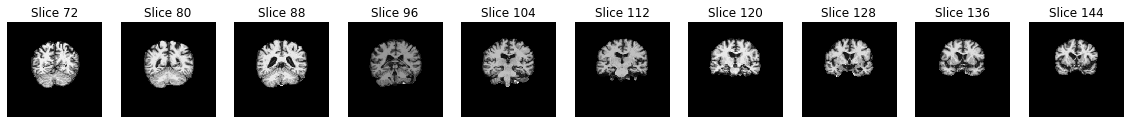

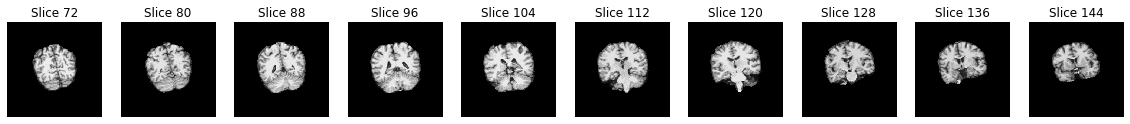

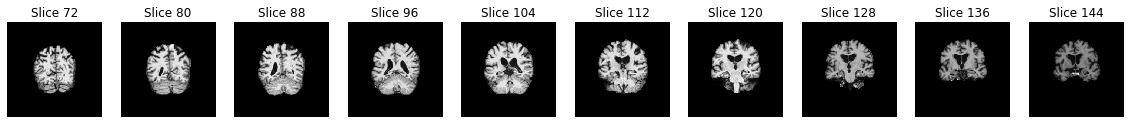

In [6]:
def show_slices(image):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    for i in range(10):
        axes[i].imshow(image[:, i, :].T, cmap="gray", origin="lower")
        axes[i].axis('off')
        axes[i].set_title('Slice {}'.format(72 + 8 * i))

show_slices(x_train[0,:,:,:,0])
show_slices(x_train[50,:,:,:,0])
show_slices(x_train[200,:,:,:,0])

# Build an ensemble based on specified slices
## Make to specify a directory to save the sub-models in the `model_path` field

In [7]:
def crop(x, z_slice=0, dims=(200, 200)):
    x = np.moveaxis(x, 2, 3)
    x = np.moveaxis(x[:,:,:,z_slice], -1, 1)
    x_new = np.zeros((x.shape[0], x.shape[1], dims[0], dims[1]))
    for i in range(len(x)):
        data = np.argwhere(x[i][0])
        min_idx = np.min(data, axis=0)
        max_idx = np.max(data, axis=0)
        crop = x[i][0][min_idx[0]:max_idx[0], min_idx[1]:max_idx[1]]
        left_right = int((dims[0]-crop.shape[0])/2)
        bottom_top = int((dims[1]-crop.shape[1])/2)
        x_new[i][0] = np.pad(crop, ((left_right, dims[0]-crop.shape[0]-left_right), (dims[1]-crop.shape[1]-bottom_top, bottom_top)))
        
    return x_new

def min_max(x):
    for i in range(len(x)):
        x[i] -= np.min(x[i])
        x[i] /= np.max(x[i])
    
    return x

Starting slice 0
(1330, 1, 200, 200)
(148, 1, 200, 200)
C:/Users/Ben/Desktop/MRI_Mask/trained_cn_ad_mri
Starting trial 0


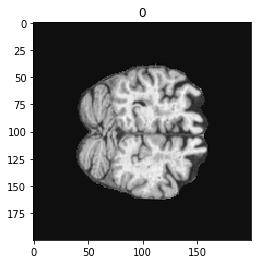

[0,   100] loss: 0.75274
[0,   200] loss: 0.68975
[0,   300] loss: 0.68218
Time elapsed: 0h:0m:28s
train accuracy_score: 55.79 %
val accuracy_score: 58.78 %
Val loss: 0.677440
[1,   100] loss: 0.68090
[1,   200] loss: 0.64887
[1,   300] loss: 0.63316
Time elapsed: 0h:1m:0s
train accuracy_score: 60.83 %
val accuracy_score: 62.84 %
Val loss: 0.663764
[2,   100] loss: 0.64241
[2,   200] loss: 0.65199
[2,   300] loss: 0.61986
Time elapsed: 0h:1m:30s
train accuracy_score: 64.96 %
val accuracy_score: 64.86 %
Val loss: 0.646581
[3,   100] loss: 0.60645
[3,   200] loss: 0.65205
[3,   300] loss: 0.63683
Time elapsed: 0h:1m:59s
train accuracy_score: 65.34 %
val accuracy_score: 64.86 %
Val loss: 0.642425
[4,   100] loss: 0.61064
[4,   200] loss: 0.64265
[4,   300] loss: 0.58506
Time elapsed: 0h:2m:30s
train accuracy_score: 66.54 %
val accuracy_score: 64.19 %
Val loss: 0.658260
[5,   100] loss: 0.60905
[5,   200] loss: 0.59024
[5,   300] loss: 0.61518
Time elapsed: 0h:3m:0s
train accuracy_score: 6

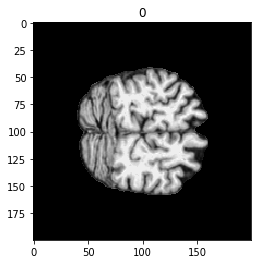

[0,   100] loss: 0.70569
[0,   200] loss: 0.69688
[0,   300] loss: 0.70116
Time elapsed: 0h:0m:27s
train accuracy_score: 57.67 %
val accuracy_score: 63.51 %
Val loss: 0.659564
[1,   100] loss: 0.65436
[1,   200] loss: 0.64111
[1,   300] loss: 0.66139
Time elapsed: 0h:0m:55s
train accuracy_score: 63.46 %
val accuracy_score: 64.19 %
Val loss: 0.653718
[2,   100] loss: 0.62274
[2,   200] loss: 0.63146
[2,   300] loss: 0.63880
Time elapsed: 0h:1m:24s
train accuracy_score: 65.41 %
val accuracy_score: 64.19 %
Val loss: 0.643291
[3,   100] loss: 0.58762
[3,   200] loss: 0.63833
[3,   300] loss: 0.59678
Time elapsed: 0h:1m:52s
train accuracy_score: 65.94 %
val accuracy_score: 66.89 %
Val loss: 0.638811
[4,   100] loss: 0.65117
[4,   200] loss: 0.61368
[4,   300] loss: 0.58040
Time elapsed: 0h:2m:21s
train accuracy_score: 66.54 %
val accuracy_score: 66.89 %
Val loss: 0.630241
[5,   100] loss: 0.57477
[5,   200] loss: 0.61084
[5,   300] loss: 0.59277
Time elapsed: 0h:2m:50s
train accuracy_score:

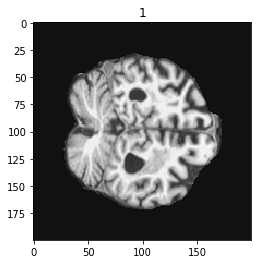

[0,   100] loss: 0.72026
[0,   200] loss: 0.70070
[0,   300] loss: 0.68754
Time elapsed: 0h:0m:27s
train accuracy_score: 55.49 %
val accuracy_score: 66.22 %
Val loss: 0.657388
[1,   100] loss: 0.66896
[1,   200] loss: 0.64434
[1,   300] loss: 0.65126
Time elapsed: 0h:0m:56s
train accuracy_score: 61.88 %
val accuracy_score: 65.54 %
Val loss: 0.633496
[2,   100] loss: 0.64961
[2,   200] loss: 0.65079
[2,   300] loss: 0.62629
Time elapsed: 0h:1m:25s
train accuracy_score: 63.16 %
val accuracy_score: 62.16 %
Val loss: 0.660826
[3,   100] loss: 0.59976
[3,   200] loss: 0.62116
[3,   300] loss: 0.61216
Time elapsed: 0h:1m:55s
train accuracy_score: 65.11 %
val accuracy_score: 67.57 %
Val loss: 0.618254
[4,   100] loss: 0.61342
[4,   200] loss: 0.60788
[4,   300] loss: 0.56292
Time elapsed: 0h:2m:25s
train accuracy_score: 68.27 %
val accuracy_score: 68.92 %
Val loss: 0.614709
[5,   100] loss: 0.60451
[5,   200] loss: 0.57806
[5,   300] loss: 0.59229
Time elapsed: 0h:2m:53s
train accuracy_score:

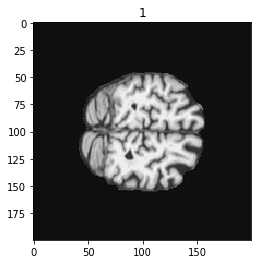

[0,   100] loss: 0.71879
[0,   200] loss: 0.70346
[0,   300] loss: 0.68458
Time elapsed: 0h:0m:28s
train accuracy_score: 55.04 %
val accuracy_score: 60.14 %
Val loss: 0.662440
[1,   100] loss: 0.65075
[1,   200] loss: 0.68464
[1,   300] loss: 0.64775
Time elapsed: 0h:0m:57s
train accuracy_score: 60.45 %
val accuracy_score: 58.78 %
Val loss: 0.675351
[2,   100] loss: 0.64256
[2,   200] loss: 0.65890
[2,   300] loss: 0.64023
Time elapsed: 0h:1m:26s
train accuracy_score: 63.16 %
val accuracy_score: 62.84 %
Val loss: 0.668866
[3,   100] loss: 0.64366
[3,   200] loss: 0.61790
[3,   300] loss: 0.60016
Time elapsed: 0h:1m:55s
train accuracy_score: 65.86 %
val accuracy_score: 56.76 %
Val loss: 0.681823
[4,   100] loss: 0.63353
[4,   200] loss: 0.60255
[4,   300] loss: 0.63489
Time elapsed: 0h:2m:24s
train accuracy_score: 66.17 %
val accuracy_score: 66.89 %
Val loss: 0.639774
[5,   100] loss: 0.59413
[5,   200] loss: 0.64993
[5,   300] loss: 0.59890
Time elapsed: 0h:2m:53s
train accuracy_score:

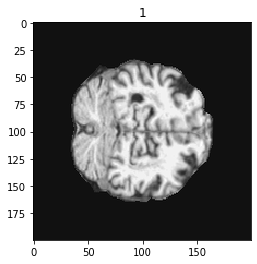

[0,   100] loss: 0.69777
[0,   200] loss: 0.70034
[0,   300] loss: 0.69423
Time elapsed: 0h:0m:27s
train accuracy_score: 58.05 %
val accuracy_score: 60.81 %
Val loss: 0.657223
[1,   100] loss: 0.66705
[1,   200] loss: 0.66832
[1,   300] loss: 0.66027
Time elapsed: 0h:0m:57s
train accuracy_score: 60.60 %
val accuracy_score: 64.19 %
Val loss: 0.645722
[2,   100] loss: 0.67684
[2,   200] loss: 0.64306
[2,   300] loss: 0.63574
Time elapsed: 0h:1m:25s
train accuracy_score: 62.71 %
val accuracy_score: 67.57 %
Val loss: 0.641406
[3,   100] loss: 0.62474
[3,   200] loss: 0.65094
[3,   300] loss: 0.65151
Time elapsed: 0h:1m:54s
train accuracy_score: 64.21 %
val accuracy_score: 63.51 %
Val loss: 0.643068
[4,   100] loss: 0.63000
[4,   200] loss: 0.63437
[4,   300] loss: 0.65460
Time elapsed: 0h:2m:24s
train accuracy_score: 63.76 %
val accuracy_score: 64.86 %
Val loss: 0.646396
[5,   100] loss: 0.61501
[5,   200] loss: 0.63810
[5,   300] loss: 0.60790
Time elapsed: 0h:2m:55s
train accuracy_score:

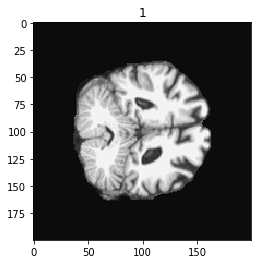

[0,   100] loss: 0.70530
[0,   200] loss: 0.71635
[0,   300] loss: 0.67120
Time elapsed: 0h:0m:27s
train accuracy_score: 57.14 %
val accuracy_score: 63.51 %
Val loss: 0.639752
[1,   100] loss: 0.66104
[1,   200] loss: 0.66165
[1,   300] loss: 0.64792
Time elapsed: 0h:0m:56s
train accuracy_score: 62.86 %
val accuracy_score: 60.81 %
Val loss: 0.657655
[2,   100] loss: 0.62628
[2,   200] loss: 0.61207
[2,   300] loss: 0.60313
Time elapsed: 0h:1m:25s
train accuracy_score: 66.47 %
val accuracy_score: 70.95 %
Val loss: 0.604199
[3,   100] loss: 0.58480
[3,   200] loss: 0.61313
[3,   300] loss: 0.58172
Time elapsed: 0h:1m:53s
train accuracy_score: 68.05 %
val accuracy_score: 70.27 %
Val loss: 0.601153
[4,   100] loss: 0.62849
[4,   200] loss: 0.57652
[4,   300] loss: 0.56054
Time elapsed: 0h:2m:23s
train accuracy_score: 69.25 %
val accuracy_score: 75.00 %
Val loss: 0.596623
[5,   100] loss: 0.56541
[5,   200] loss: 0.56391
[5,   300] loss: 0.57405
Time elapsed: 0h:2m:53s
train accuracy_score:

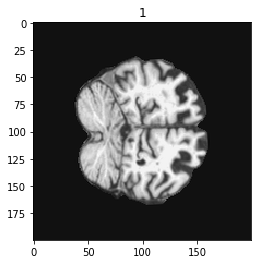

[0,   100] loss: 0.76832
[0,   200] loss: 0.68579
[0,   300] loss: 0.70791
Time elapsed: 0h:0m:46s
train accuracy_score: 53.68 %
val accuracy_score: 58.78 %
Val loss: 0.660840
[1,   100] loss: 0.64622
[1,   200] loss: 0.66582
[1,   300] loss: 0.62926
Time elapsed: 0h:1m:33s
train accuracy_score: 62.11 %
val accuracy_score: 62.16 %
Val loss: 0.644400
[2,   100] loss: 0.59440
[2,   200] loss: 0.64210
[2,   300] loss: 0.64172
Time elapsed: 0h:2m:21s
train accuracy_score: 65.04 %
val accuracy_score: 50.00 %
Val loss: 0.720276
[3,   100] loss: 0.63828
[3,   200] loss: 0.61744
[3,   300] loss: 0.62017
Time elapsed: 0h:3m:10s
train accuracy_score: 65.56 %
val accuracy_score: 66.89 %
Val loss: 0.618459
[4,   100] loss: 0.60789
[4,   200] loss: 0.61422
[4,   300] loss: 0.55799
Time elapsed: 0h:3m:59s
train accuracy_score: 69.70 %
val accuracy_score: 67.57 %
Val loss: 0.622739
[5,   100] loss: 0.58179
[5,   200] loss: 0.60246
[5,   300] loss: 0.58933
Time elapsed: 0h:4m:47s
train accuracy_score:

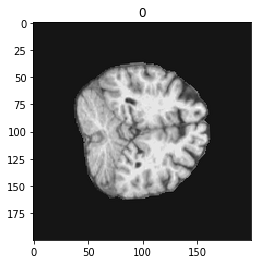

[0,   100] loss: 0.73809
[0,   200] loss: 0.67419
[0,   300] loss: 0.71433
Time elapsed: 0h:0m:43s
train accuracy_score: 56.84 %
val accuracy_score: 66.89 %
Val loss: 0.643667
[1,   100] loss: 0.66911
[1,   200] loss: 0.65186
[1,   300] loss: 0.60648
Time elapsed: 0h:1m:30s
train accuracy_score: 62.63 %
val accuracy_score: 64.19 %
Val loss: 0.622531
[2,   100] loss: 0.63595
[2,   200] loss: 0.62399
[2,   300] loss: 0.63131
Time elapsed: 0h:2m:17s
train accuracy_score: 65.86 %
val accuracy_score: 68.92 %
Val loss: 0.609384
[3,   100] loss: 0.58728
[3,   200] loss: 0.59578
[3,   300] loss: 0.58780
Time elapsed: 0h:3m:5s
train accuracy_score: 68.57 %
val accuracy_score: 64.86 %
Val loss: 0.599197
[4,   100] loss: 0.58800
[4,   200] loss: 0.58248
[4,   300] loss: 0.55263
Time elapsed: 0h:3m:51s
train accuracy_score: 69.40 %
val accuracy_score: 63.51 %
Val loss: 0.640912
[5,   100] loss: 0.58256
[5,   200] loss: 0.59034
[5,   300] loss: 0.55831
Time elapsed: 0h:4m:37s
train accuracy_score: 

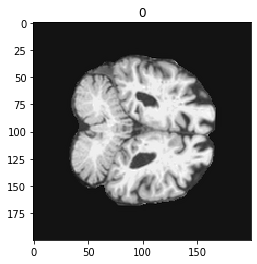

[0,   100] loss: 0.73347
[0,   200] loss: 0.70545
[0,   300] loss: 0.67390
Time elapsed: 0h:0m:53s
train accuracy_score: 57.67 %
val accuracy_score: 58.78 %
Val loss: 0.658674
[1,   100] loss: 0.66873
[1,   200] loss: 0.64602
[1,   300] loss: 0.63296
Time elapsed: 0h:1m:37s
train accuracy_score: 61.95 %
val accuracy_score: 64.86 %
Val loss: 0.628131
[2,   100] loss: 0.62934
[2,   200] loss: 0.61544
[2,   300] loss: 0.61343
Time elapsed: 0h:2m:24s
train accuracy_score: 66.32 %
val accuracy_score: 68.24 %
Val loss: 0.638348
[3,   100] loss: 0.55692
[3,   200] loss: 0.60065
[3,   300] loss: 0.62094
Time elapsed: 0h:3m:11s
train accuracy_score: 68.35 %
val accuracy_score: 68.24 %
Val loss: 0.630180
[4,   100] loss: 0.59884
[4,   200] loss: 0.59463
[4,   300] loss: 0.58639
Time elapsed: 0h:4m:8s
train accuracy_score: 68.20 %
val accuracy_score: 66.89 %
Val loss: 0.615230
[5,   100] loss: 0.53573
[5,   200] loss: 0.57589
[5,   300] loss: 0.58310
Time elapsed: 0h:5m:4s
train accuracy_score: 7

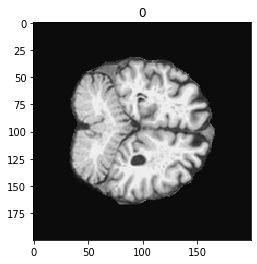

[0,   100] loss: 0.73050
[0,   200] loss: 0.68234
[0,   300] loss: 0.69983
Time elapsed: 0h:0m:48s
train accuracy_score: 56.24 %
val accuracy_score: 60.14 %
Val loss: 0.657759
[1,   100] loss: 0.65344
[1,   200] loss: 0.65120
[1,   300] loss: 0.63909
Time elapsed: 0h:1m:38s
train accuracy_score: 62.18 %
val accuracy_score: 68.24 %
Val loss: 0.628968
[2,   100] loss: 0.59127
[2,   200] loss: 0.64636
[2,   300] loss: 0.61702
Time elapsed: 0h:2m:27s
train accuracy_score: 67.44 %
val accuracy_score: 66.89 %
Val loss: 0.620771
[3,   100] loss: 0.59682
[3,   200] loss: 0.62388
[3,   300] loss: 0.58008
Time elapsed: 0h:3m:18s
train accuracy_score: 68.20 %
val accuracy_score: 68.92 %
Val loss: 0.597125
[4,   100] loss: 0.59453
[4,   200] loss: 0.57757
[4,   300] loss: 0.61087
Time elapsed: 0h:4m:7s
train accuracy_score: 68.42 %
val accuracy_score: 70.95 %
Val loss: 0.596857
[5,   100] loss: 0.57296
[5,   200] loss: 0.55400
[5,   300] loss: 0.59722
Time elapsed: 0h:4m:57s
train accuracy_score: 

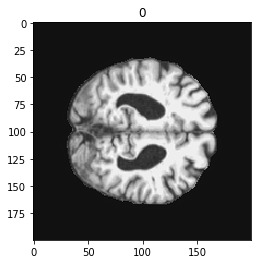

[0,   100] loss: 0.66418
[0,   200] loss: 0.71485
[0,   300] loss: 0.68705
Time elapsed: 0h:0m:50s
train accuracy_score: 59.17 %
val accuracy_score: 62.16 %
Val loss: 0.663678
[1,   100] loss: 0.65691
[1,   200] loss: 0.66069
[1,   300] loss: 0.63369
Time elapsed: 0h:1m:39s
train accuracy_score: 61.80 %
val accuracy_score: 56.76 %
Val loss: 0.668002
[2,   100] loss: 0.62425
[2,   200] loss: 0.64799
[2,   300] loss: 0.61302
Time elapsed: 0h:2m:28s
train accuracy_score: 63.91 %
val accuracy_score: 63.51 %
Val loss: 0.649072
[3,   100] loss: 0.58670
[3,   200] loss: 0.62779
[3,   300] loss: 0.60512
Time elapsed: 0h:3m:16s
train accuracy_score: 67.52 %
val accuracy_score: 64.19 %
Val loss: 0.648734
[4,   100] loss: 0.59862
[4,   200] loss: 0.62101
[4,   300] loss: 0.58721
Time elapsed: 0h:4m:5s
train accuracy_score: 67.67 %
val accuracy_score: 63.51 %
Val loss: 0.646336
[5,   100] loss: 0.56584
[5,   200] loss: 0.60874
[5,   300] loss: 0.59343
Time elapsed: 0h:4m:53s
train accuracy_score: 

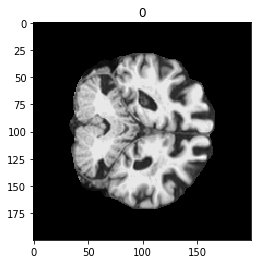

[0,   100] loss: 0.71655
[0,   200] loss: 0.71798
[0,   300] loss: 0.66983
Time elapsed: 0h:0m:59s
train accuracy_score: 58.87 %
val accuracy_score: 59.46 %
Val loss: 0.677566
[1,   100] loss: 0.64984
[1,   200] loss: 0.63288
[1,   300] loss: 0.66414
Time elapsed: 0h:1m:54s
train accuracy_score: 61.50 %
val accuracy_score: 64.86 %
Val loss: 0.650919
[2,   100] loss: 0.65469
[2,   200] loss: 0.63269
[2,   300] loss: 0.61262
Time elapsed: 0h:2m:48s
train accuracy_score: 64.14 %
val accuracy_score: 65.54 %
Val loss: 0.644148
[3,   100] loss: 0.60663
[3,   200] loss: 0.59565
[3,   300] loss: 0.60796
Time elapsed: 0h:3m:30s
train accuracy_score: 66.92 %
val accuracy_score: 68.92 %
Val loss: 0.638892
[4,   100] loss: 0.58189
[4,   200] loss: 0.61345
[4,   300] loss: 0.56093
Time elapsed: 0h:4m:12s
train accuracy_score: 70.98 %
val accuracy_score: 65.54 %
Val loss: 0.630897
[5,   100] loss: 0.61432
[5,   200] loss: 0.56115
[5,   300] loss: 0.54420
Time elapsed: 0h:5m:1s
train accuracy_score: 

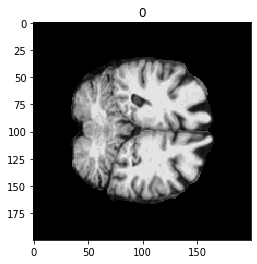

[0,   100] loss: 0.72358
[0,   200] loss: 0.68900
[0,   300] loss: 0.66998
Time elapsed: 0h:0m:47s
train accuracy_score: 57.82 %
val accuracy_score: 61.49 %
Val loss: 0.649503
[1,   100] loss: 0.67324
[1,   200] loss: 0.68310
[1,   300] loss: 0.63231
Time elapsed: 0h:1m:31s
train accuracy_score: 61.88 %
val accuracy_score: 63.51 %
Val loss: 0.634800
[2,   100] loss: 0.61523
[2,   200] loss: 0.64649
[2,   300] loss: 0.62723
Time elapsed: 0h:2m:23s
train accuracy_score: 64.81 %
val accuracy_score: 62.84 %
Val loss: 0.651667
[3,   100] loss: 0.63294
[3,   200] loss: 0.59527
[3,   300] loss: 0.60595
Time elapsed: 0h:3m:17s
train accuracy_score: 66.24 %
val accuracy_score: 66.22 %
Val loss: 0.621314
[4,   100] loss: 0.58201
[4,   200] loss: 0.60818
[4,   300] loss: 0.58180
Time elapsed: 0h:4m:10s
train accuracy_score: 68.65 %
val accuracy_score: 66.22 %
Val loss: 0.615672
[5,   100] loss: 0.57589
[5,   200] loss: 0.60058
[5,   300] loss: 0.57185
Time elapsed: 0h:5m:2s
train accuracy_score: 

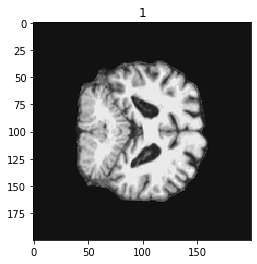

[0,   100] loss: 0.75236
[0,   200] loss: 0.69722
[0,   300] loss: 0.67775
Time elapsed: 0h:0m:47s
train accuracy_score: 55.86 %
val accuracy_score: 61.49 %
Val loss: 0.657684
[1,   100] loss: 0.63137
[1,   200] loss: 0.66124
[1,   300] loss: 0.64027
Time elapsed: 0h:1m:36s
train accuracy_score: 62.41 %
val accuracy_score: 56.08 %
Val loss: 0.679716
[2,   100] loss: 0.59805
[2,   200] loss: 0.65533
[2,   300] loss: 0.62577
Time elapsed: 0h:2m:25s
train accuracy_score: 66.32 %
val accuracy_score: 56.76 %
Val loss: 0.668489
[3,   100] loss: 0.61446
[3,   200] loss: 0.60872
[3,   300] loss: 0.58230
Time elapsed: 0h:3m:13s
train accuracy_score: 66.77 %
val accuracy_score: 56.08 %
Val loss: 0.702450
[4,   100] loss: 0.56789
[4,   200] loss: 0.61707
[4,   300] loss: 0.57081
Time elapsed: 0h:4m:3s
train accuracy_score: 68.72 %
val accuracy_score: 67.57 %
Val loss: 0.671417
[5,   100] loss: 0.59862
[5,   200] loss: 0.54463
[5,   300] loss: 0.53350
Time elapsed: 0h:4m:51s
train accuracy_score: 

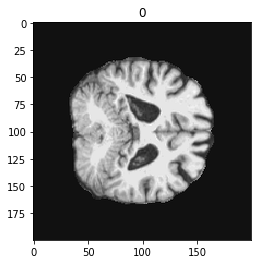

[0,   100] loss: 0.73194
[0,   200] loss: 0.70686
[0,   300] loss: 0.66299
Time elapsed: 0h:0m:48s
train accuracy_score: 57.74 %
val accuracy_score: 64.19 %
Val loss: 0.653323
[1,   100] loss: 0.66117
[1,   200] loss: 0.64969
[1,   300] loss: 0.63359
Time elapsed: 0h:1m:37s
train accuracy_score: 63.68 %
val accuracy_score: 61.49 %
Val loss: 0.654073
[2,   100] loss: 0.61961
[2,   200] loss: 0.58653
[2,   300] loss: 0.62126
Time elapsed: 0h:2m:27s
train accuracy_score: 67.59 %
val accuracy_score: 58.78 %
Val loss: 0.660055
[3,   100] loss: 0.59626
[3,   200] loss: 0.56409
[3,   300] loss: 0.59946
Time elapsed: 0h:3m:17s
train accuracy_score: 68.80 %
val accuracy_score: 56.08 %
Val loss: 0.693866
[4,   100] loss: 0.58663
[4,   200] loss: 0.55988
[4,   300] loss: 0.59848
Time elapsed: 0h:4m:6s
train accuracy_score: 70.53 %
val accuracy_score: 65.54 %
Val loss: 0.642437
[5,   100] loss: 0.57711
[5,   200] loss: 0.54786
[5,   300] loss: 0.54448
Time elapsed: 0h:4m:56s
train accuracy_score: 

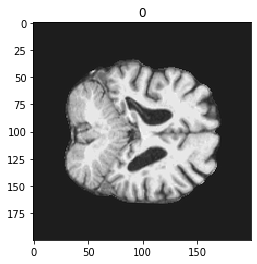

[0,   100] loss: 0.66494
[0,   200] loss: 0.72731
[0,   300] loss: 0.71440
Time elapsed: 0h:0m:47s
train accuracy_score: 55.56 %
val accuracy_score: 62.84 %
Val loss: 0.660891
[1,   100] loss: 0.63382
[1,   200] loss: 0.67652
[1,   300] loss: 0.68051
Time elapsed: 0h:1m:36s
train accuracy_score: 59.62 %
val accuracy_score: 66.22 %
Val loss: 0.644755
[2,   100] loss: 0.63825
[2,   200] loss: 0.56595
[2,   300] loss: 0.63936
Time elapsed: 0h:2m:25s
train accuracy_score: 65.41 %
val accuracy_score: 58.78 %
Val loss: 0.662749
[3,   100] loss: 0.56672
[3,   200] loss: 0.59995
[3,   300] loss: 0.59924
Time elapsed: 0h:3m:13s
train accuracy_score: 68.35 %
val accuracy_score: 67.57 %
Val loss: 0.617371
[4,   100] loss: 0.55769
[4,   200] loss: 0.55868
[4,   300] loss: 0.53887
Time elapsed: 0h:4m:1s
train accuracy_score: 72.26 %
val accuracy_score: 65.54 %
Val loss: 0.647163
[5,   100] loss: 0.54873
[5,   200] loss: 0.56817
[5,   300] loss: 0.55056
Time elapsed: 0h:4m:49s
train accuracy_score: 

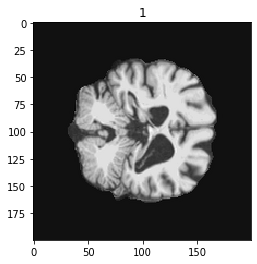

[0,   100] loss: 0.69975
[0,   200] loss: 0.67549
[0,   300] loss: 0.67278
Time elapsed: 0h:0m:46s
train accuracy_score: 56.84 %
val accuracy_score: 60.14 %
Val loss: 0.635421
[1,   100] loss: 0.64372
[1,   200] loss: 0.61870
[1,   300] loss: 0.63032
Time elapsed: 0h:1m:35s
train accuracy_score: 66.02 %
val accuracy_score: 62.84 %
Val loss: 0.638182
[2,   100] loss: 0.56902
[2,   200] loss: 0.60826
[2,   300] loss: 0.57981
Time elapsed: 0h:2m:24s
train accuracy_score: 68.80 %
val accuracy_score: 56.76 %
Val loss: 0.663351
[3,   100] loss: 0.55640
[3,   200] loss: 0.58773
[3,   300] loss: 0.57346
Time elapsed: 0h:3m:13s
train accuracy_score: 69.32 %
val accuracy_score: 70.27 %
Val loss: 0.582671
[4,   100] loss: 0.53800
[4,   200] loss: 0.51838
[4,   300] loss: 0.56185
Time elapsed: 0h:4m:12s
train accuracy_score: 72.03 %
val accuracy_score: 72.97 %
Val loss: 0.559791
[5,   100] loss: 0.49400
[5,   200] loss: 0.52341
[5,   300] loss: 0.55342
Time elapsed: 0h:5m:10s
train accuracy_score:

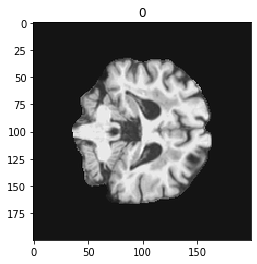

[0,   100] loss: 0.71593
[0,   200] loss: 0.69267
[0,   300] loss: 0.67575
Time elapsed: 0h:0m:28s
train accuracy_score: 59.92 %
val accuracy_score: 60.14 %
Val loss: 0.652400
[1,   100] loss: 0.66698
[1,   200] loss: 0.66045
[1,   300] loss: 0.64391
Time elapsed: 0h:0m:57s
train accuracy_score: 61.88 %
val accuracy_score: 65.54 %
Val loss: 0.637107
[2,   100] loss: 0.61906
[2,   200] loss: 0.61886
[2,   300] loss: 0.61653
Time elapsed: 0h:1m:26s
train accuracy_score: 66.54 %
val accuracy_score: 68.24 %
Val loss: 0.619461
[3,   100] loss: 0.58654
[3,   200] loss: 0.61569
[3,   300] loss: 0.59791
Time elapsed: 0h:1m:55s
train accuracy_score: 70.23 %
val accuracy_score: 68.24 %
Val loss: 0.626820
[4,   100] loss: 0.57147
[4,   200] loss: 0.57282
[4,   300] loss: 0.56033
Time elapsed: 0h:2m:24s
train accuracy_score: 71.65 %
val accuracy_score: 70.95 %
Val loss: 0.581337
[5,   100] loss: 0.56023
[5,   200] loss: 0.55713
[5,   300] loss: 0.54164
Time elapsed: 0h:2m:53s
train accuracy_score:

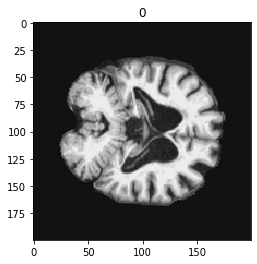

[0,   100] loss: 0.71843
[0,   200] loss: 0.70931
[0,   300] loss: 0.65210
Time elapsed: 0h:0m:28s
train accuracy_score: 58.42 %
val accuracy_score: 58.78 %
Val loss: 0.646874
[1,   100] loss: 0.67512
[1,   200] loss: 0.64550
[1,   300] loss: 0.66518
Time elapsed: 0h:0m:57s
train accuracy_score: 60.83 %
val accuracy_score: 59.46 %
Val loss: 0.690858
[2,   100] loss: 0.62283
[2,   200] loss: 0.60561
[2,   300] loss: 0.57985
Time elapsed: 0h:1m:26s
train accuracy_score: 66.99 %
val accuracy_score: 56.08 %
Val loss: 0.677843
[3,   100] loss: 0.58533
[3,   200] loss: 0.59055
[3,   300] loss: 0.61961
Time elapsed: 0h:1m:55s
train accuracy_score: 67.97 %
val accuracy_score: 75.68 %
Val loss: 0.579321
[4,   100] loss: 0.52890
[4,   200] loss: 0.58556
[4,   300] loss: 0.57883
Time elapsed: 0h:2m:24s
train accuracy_score: 71.20 %
val accuracy_score: 67.57 %
Val loss: 0.611802
[5,   100] loss: 0.53985
[5,   200] loss: 0.51156
[5,   300] loss: 0.52506
Time elapsed: 0h:2m:53s
train accuracy_score:

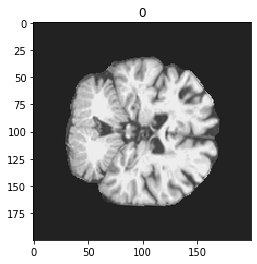

[0,   100] loss: 0.69759
[0,   200] loss: 0.69934
[0,   300] loss: 0.68358
Time elapsed: 0h:0m:27s
train accuracy_score: 56.99 %
val accuracy_score: 60.14 %
Val loss: 0.652476
[1,   100] loss: 0.68076
[1,   200] loss: 0.67074
[1,   300] loss: 0.65460
Time elapsed: 0h:0m:57s
train accuracy_score: 61.65 %
val accuracy_score: 62.84 %
Val loss: 0.657959
[2,   100] loss: 0.63422
[2,   200] loss: 0.65300
[2,   300] loss: 0.60973
Time elapsed: 0h:1m:25s
train accuracy_score: 65.04 %
val accuracy_score: 64.86 %
Val loss: 0.623166
[3,   100] loss: 0.63155
[3,   200] loss: 0.62404
[3,   300] loss: 0.59649
Time elapsed: 0h:1m:54s
train accuracy_score: 66.17 %
val accuracy_score: 62.84 %
Val loss: 0.640090
[4,   100] loss: 0.59401
[4,   200] loss: 0.62102
[4,   300] loss: 0.60090
Time elapsed: 0h:2m:23s
train accuracy_score: 68.12 %
val accuracy_score: 68.24 %
Val loss: 0.612038
[5,   100] loss: 0.56648
[5,   200] loss: 0.54913
[5,   300] loss: 0.55448
Time elapsed: 0h:2m:52s
train accuracy_score:

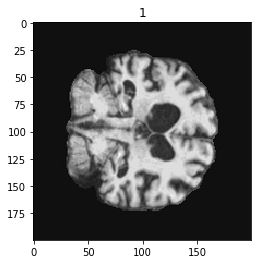

[0,   100] loss: 0.71583
[0,   200] loss: 0.71299
[0,   300] loss: 0.68689
Time elapsed: 0h:0m:28s
train accuracy_score: 56.62 %
val accuracy_score: 60.14 %
Val loss: 0.657959
[1,   100] loss: 0.66344
[1,   200] loss: 0.65792
[1,   300] loss: 0.63769
Time elapsed: 0h:0m:57s
train accuracy_score: 61.65 %
val accuracy_score: 62.16 %
Val loss: 0.647730
[2,   100] loss: 0.63447
[2,   200] loss: 0.62638
[2,   300] loss: 0.60672
Time elapsed: 0h:1m:26s
train accuracy_score: 64.74 %
val accuracy_score: 59.46 %
Val loss: 0.644038
[3,   100] loss: 0.63841
[3,   200] loss: 0.57977
[3,   300] loss: 0.60441
Time elapsed: 0h:1m:55s
train accuracy_score: 69.32 %
val accuracy_score: 67.57 %
Val loss: 0.601247
[4,   100] loss: 0.57793
[4,   200] loss: 0.52637
[4,   300] loss: 0.51792
Time elapsed: 0h:2m:23s
train accuracy_score: 71.95 %
val accuracy_score: 75.00 %
Val loss: 0.560939
[5,   100] loss: 0.50820
[5,   200] loss: 0.52682
[5,   300] loss: 0.51898
Time elapsed: 0h:2m:52s
train accuracy_score:

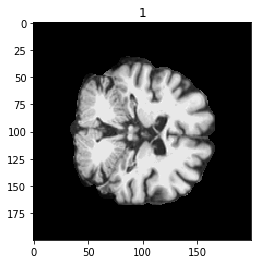

[0,   100] loss: 0.72166
[0,   200] loss: 0.69015
[0,   300] loss: 0.66423
Time elapsed: 0h:0m:28s
train accuracy_score: 58.95 %
val accuracy_score: 59.46 %
Val loss: 0.657465
[1,   100] loss: 0.64821
[1,   200] loss: 0.68121
[1,   300] loss: 0.66052
Time elapsed: 0h:0m:56s
train accuracy_score: 61.50 %
val accuracy_score: 59.46 %
Val loss: 0.657429
[2,   100] loss: 0.61637
[2,   200] loss: 0.62552
[2,   300] loss: 0.61519
Time elapsed: 0h:1m:25s
train accuracy_score: 66.02 %
val accuracy_score: 67.57 %
Val loss: 0.603749
[3,   100] loss: 0.60348
[3,   200] loss: 0.61647
[3,   300] loss: 0.60219
Time elapsed: 0h:1m:54s
train accuracy_score: 66.62 %
val accuracy_score: 64.19 %
Val loss: 0.625112
[4,   100] loss: 0.55585
[4,   200] loss: 0.58716
[4,   300] loss: 0.54850
Time elapsed: 0h:2m:22s
train accuracy_score: 71.20 %
val accuracy_score: 71.62 %
Val loss: 0.578060
[5,   100] loss: 0.60204
[5,   200] loss: 0.53340
[5,   300] loss: 0.53150
Time elapsed: 0h:2m:51s
train accuracy_score:

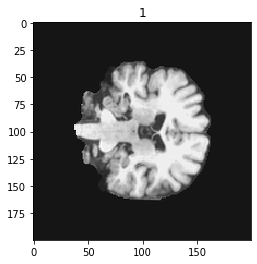

[0,   100] loss: 0.72107
[0,   200] loss: 0.70782
[0,   300] loss: 0.65871
Time elapsed: 0h:0m:27s
train accuracy_score: 58.35 %
val accuracy_score: 60.14 %
Val loss: 0.657637
[1,   100] loss: 0.67047
[1,   200] loss: 0.65204
[1,   300] loss: 0.65854
Time elapsed: 0h:0m:56s
train accuracy_score: 60.60 %
val accuracy_score: 66.89 %
Val loss: 0.635427
[2,   100] loss: 0.63379
[2,   200] loss: 0.62614
[2,   300] loss: 0.61371
Time elapsed: 0h:1m:25s
train accuracy_score: 64.29 %
val accuracy_score: 68.24 %
Val loss: 0.604695
[3,   100] loss: 0.57380
[3,   200] loss: 0.57628
[3,   300] loss: 0.56906
Time elapsed: 0h:1m:54s
train accuracy_score: 70.38 %
val accuracy_score: 69.59 %
Val loss: 0.569689
[4,   100] loss: 0.54935
[4,   200] loss: 0.50834
[4,   300] loss: 0.54306
Time elapsed: 0h:2m:23s
train accuracy_score: 72.63 %
val accuracy_score: 68.24 %
Val loss: 0.610116
[5,   100] loss: 0.49486
[5,   200] loss: 0.48481
[5,   300] loss: 0.54315
Time elapsed: 0h:2m:51s
train accuracy_score:

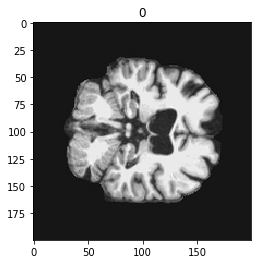

[0,   100] loss: 0.74071
[0,   200] loss: 0.68160
[0,   300] loss: 0.68709
Time elapsed: 0h:0m:28s
train accuracy_score: 56.54 %
val accuracy_score: 72.30 %
Val loss: 0.646558
[1,   100] loss: 0.64952
[1,   200] loss: 0.64543
[1,   300] loss: 0.61366
Time elapsed: 0h:0m:56s
train accuracy_score: 64.06 %
val accuracy_score: 63.51 %
Val loss: 0.624741
[2,   100] loss: 0.59981
[2,   200] loss: 0.62526
[2,   300] loss: 0.59752
Time elapsed: 0h:1m:25s
train accuracy_score: 65.11 %
val accuracy_score: 72.97 %
Val loss: 0.579613
[3,   100] loss: 0.56264
[3,   200] loss: 0.58122
[3,   300] loss: 0.56179
Time elapsed: 0h:1m:54s
train accuracy_score: 69.55 %
val accuracy_score: 67.57 %
Val loss: 0.589712
[4,   100] loss: 0.57306
[4,   200] loss: 0.49470
[4,   300] loss: 0.58024
Time elapsed: 0h:2m:23s
train accuracy_score: 72.56 %
val accuracy_score: 75.00 %
Val loss: 0.544567
[5,   100] loss: 0.55471
[5,   200] loss: 0.50169
[5,   300] loss: 0.51444
Time elapsed: 0h:2m:52s
train accuracy_score:

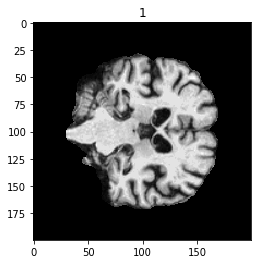

[0,   100] loss: 0.74391
[0,   200] loss: 0.71664
[0,   300] loss: 0.68103
Time elapsed: 0h:0m:27s
train accuracy_score: 55.79 %
val accuracy_score: 60.14 %
Val loss: 0.659931
[1,   100] loss: 0.66261
[1,   200] loss: 0.66508
[1,   300] loss: 0.66772
Time elapsed: 0h:0m:56s
train accuracy_score: 60.23 %
val accuracy_score: 62.84 %
Val loss: 0.638635
[2,   100] loss: 0.64600
[2,   200] loss: 0.61546
[2,   300] loss: 0.59806
Time elapsed: 0h:1m:25s
train accuracy_score: 66.99 %
val accuracy_score: 66.89 %
Val loss: 0.615808
[3,   100] loss: 0.61311
[3,   200] loss: 0.61202
[3,   300] loss: 0.61053
Time elapsed: 0h:1m:55s
train accuracy_score: 67.67 %
val accuracy_score: 67.57 %
Val loss: 0.584248
[4,   100] loss: 0.58062
[4,   200] loss: 0.54010
[4,   300] loss: 0.58463
Time elapsed: 0h:2m:23s
train accuracy_score: 70.75 %
val accuracy_score: 72.30 %
Val loss: 0.566414
[5,   100] loss: 0.56154
[5,   200] loss: 0.52718
[5,   300] loss: 0.53956
Time elapsed: 0h:2m:53s
train accuracy_score:

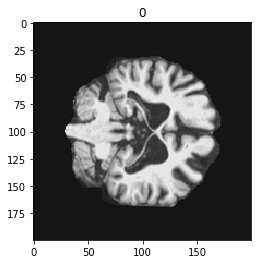

[0,   100] loss: 0.75782
[0,   200] loss: 0.68464
[0,   300] loss: 0.68924
Time elapsed: 0h:0m:27s
train accuracy_score: 56.24 %
val accuracy_score: 62.84 %
Val loss: 0.651410
[1,   100] loss: 0.66528
[1,   200] loss: 0.67362
[1,   300] loss: 0.68669
Time elapsed: 0h:0m:57s
train accuracy_score: 59.32 %
val accuracy_score: 59.46 %
Val loss: 0.657611
[2,   100] loss: 0.64822
[2,   200] loss: 0.63148
[2,   300] loss: 0.62827
Time elapsed: 0h:1m:25s
train accuracy_score: 63.68 %
val accuracy_score: 72.30 %
Val loss: 0.614948
[3,   100] loss: 0.61890
[3,   200] loss: 0.62235
[3,   300] loss: 0.60935
Time elapsed: 0h:1m:54s
train accuracy_score: 65.11 %
val accuracy_score: 75.00 %
Val loss: 0.584650
[4,   100] loss: 0.55610
[4,   200] loss: 0.56364
[4,   300] loss: 0.54960
Time elapsed: 0h:2m:22s
train accuracy_score: 71.80 %
val accuracy_score: 70.27 %
Val loss: 0.577809
[5,   100] loss: 0.55236
[5,   200] loss: 0.52652
[5,   300] loss: 0.53429
Time elapsed: 0h:2m:51s
train accuracy_score:

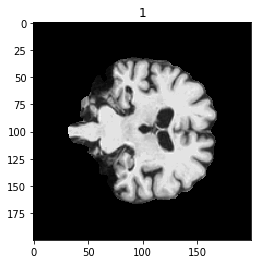

[0,   100] loss: 0.73328
[0,   200] loss: 0.68686
[0,   300] loss: 0.68720
Time elapsed: 0h:0m:28s
train accuracy_score: 56.92 %
val accuracy_score: 59.46 %
Val loss: 0.680353
[1,   100] loss: 0.65398
[1,   200] loss: 0.62118
[1,   300] loss: 0.63779
Time elapsed: 0h:0m:56s
train accuracy_score: 65.56 %
val accuracy_score: 70.95 %
Val loss: 0.599284
[2,   100] loss: 0.61446
[2,   200] loss: 0.61959
[2,   300] loss: 0.58792
Time elapsed: 0h:1m:25s
train accuracy_score: 67.14 %
val accuracy_score: 72.97 %
Val loss: 0.581053
[3,   100] loss: 0.51582
[3,   200] loss: 0.58196
[3,   300] loss: 0.56796
Time elapsed: 0h:1m:54s
train accuracy_score: 73.16 %
val accuracy_score: 70.95 %
Val loss: 0.569487
[4,   100] loss: 0.49915
[4,   200] loss: 0.55291
[4,   300] loss: 0.56282
Time elapsed: 0h:2m:22s
train accuracy_score: 74.06 %
val accuracy_score: 71.62 %
Val loss: 0.547645
[5,   100] loss: 0.54464
[5,   200] loss: 0.48474
[5,   300] loss: 0.56379
Time elapsed: 0h:2m:51s
train accuracy_score:

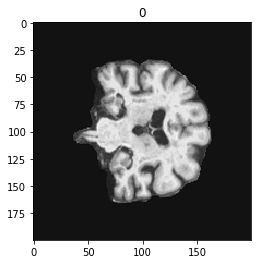

[0,   100] loss: 0.75029
[0,   200] loss: 0.68973
[0,   300] loss: 0.68127
Time elapsed: 0h:0m:27s
train accuracy_score: 57.82 %
val accuracy_score: 59.46 %
Val loss: 0.682184
[1,   100] loss: 0.65625
[1,   200] loss: 0.65631
[1,   300] loss: 0.65751
Time elapsed: 0h:0m:56s
train accuracy_score: 61.20 %
val accuracy_score: 61.49 %
Val loss: 0.639738
[2,   100] loss: 0.63206
[2,   200] loss: 0.65557
[2,   300] loss: 0.60616
Time elapsed: 0h:1m:25s
train accuracy_score: 64.89 %
val accuracy_score: 71.62 %
Val loss: 0.594643
[3,   100] loss: 0.60458
[3,   200] loss: 0.60120
[3,   300] loss: 0.54935
Time elapsed: 0h:1m:54s
train accuracy_score: 68.57 %
val accuracy_score: 67.57 %
Val loss: 0.592987
[4,   100] loss: 0.53613
[4,   200] loss: 0.54204
[4,   300] loss: 0.56420
Time elapsed: 0h:2m:22s
train accuracy_score: 72.78 %
val accuracy_score: 56.76 %
Val loss: 0.696468
[5,   100] loss: 0.56422
[5,   200] loss: 0.47710
[5,   300] loss: 0.48355
Time elapsed: 0h:2m:51s
train accuracy_score:

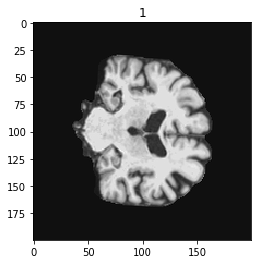

[0,   100] loss: 0.74740
[0,   200] loss: 0.66795
[0,   300] loss: 0.69976
Time elapsed: 0h:0m:27s
train accuracy_score: 56.69 %
val accuracy_score: 59.46 %
Val loss: 0.664361
[1,   100] loss: 0.66339
[1,   200] loss: 0.65887
[1,   300] loss: 0.63671
Time elapsed: 0h:0m:56s
train accuracy_score: 61.73 %
val accuracy_score: 50.68 %
Val loss: 0.687410
[2,   100] loss: 0.65448
[2,   200] loss: 0.65731
[2,   300] loss: 0.58503
Time elapsed: 0h:1m:25s
train accuracy_score: 65.04 %
val accuracy_score: 68.92 %
Val loss: 0.600952
[3,   100] loss: 0.63038
[3,   200] loss: 0.59877
[3,   300] loss: 0.59483
Time elapsed: 0h:1m:53s
train accuracy_score: 65.64 %
val accuracy_score: 71.62 %
Val loss: 0.573012
[4,   100] loss: 0.54586
[4,   200] loss: 0.58387
[4,   300] loss: 0.54229
Time elapsed: 0h:2m:22s
train accuracy_score: 71.35 %
val accuracy_score: 68.92 %
Val loss: 0.578827
[5,   100] loss: 0.52735
[5,   200] loss: 0.48994
[5,   300] loss: 0.50200
Time elapsed: 0h:2m:51s
train accuracy_score:

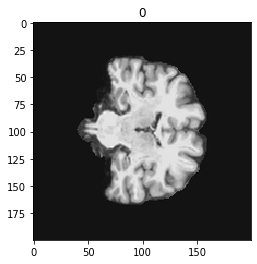

[0,   100] loss: 0.72250
[0,   200] loss: 0.67888
[0,   300] loss: 0.68458
Time elapsed: 0h:0m:27s
train accuracy_score: 57.97 %
val accuracy_score: 72.97 %
Val loss: 0.632701
[1,   100] loss: 0.64559
[1,   200] loss: 0.64454
[1,   300] loss: 0.63869
Time elapsed: 0h:0m:56s
train accuracy_score: 64.21 %
val accuracy_score: 62.84 %
Val loss: 0.637109
[2,   100] loss: 0.58176
[2,   200] loss: 0.57403
[2,   300] loss: 0.62347
Time elapsed: 0h:1m:25s
train accuracy_score: 68.57 %
val accuracy_score: 74.32 %
Val loss: 0.565394
[3,   100] loss: 0.54971
[3,   200] loss: 0.59309
[3,   300] loss: 0.51447
Time elapsed: 0h:1m:53s
train accuracy_score: 73.46 %
val accuracy_score: 70.95 %
Val loss: 0.562400
[4,   100] loss: 0.52052
[4,   200] loss: 0.54110
[4,   300] loss: 0.52118
Time elapsed: 0h:2m:22s
train accuracy_score: 75.79 %
val accuracy_score: 70.95 %
Val loss: 0.562835
[5,   100] loss: 0.45583
[5,   200] loss: 0.51038
[5,   300] loss: 0.49059
Time elapsed: 0h:2m:51s
train accuracy_score:

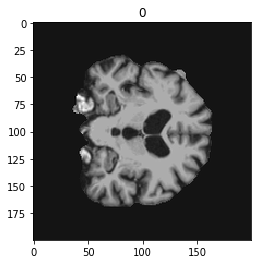

[0,   100] loss: 0.67902
[0,   200] loss: 0.69338
[0,   300] loss: 0.68647
Time elapsed: 0h:0m:27s
train accuracy_score: 57.82 %
val accuracy_score: 60.14 %
Val loss: 0.655341
[1,   100] loss: 0.66809
[1,   200] loss: 0.65168
[1,   300] loss: 0.63843
Time elapsed: 0h:0m:56s
train accuracy_score: 61.80 %
val accuracy_score: 64.86 %
Val loss: 0.628016
[2,   100] loss: 0.62078
[2,   200] loss: 0.62812
[2,   300] loss: 0.63612
Time elapsed: 0h:1m:25s
train accuracy_score: 66.77 %
val accuracy_score: 70.95 %
Val loss: 0.606365
[3,   100] loss: 0.56574
[3,   200] loss: 0.59653
[3,   300] loss: 0.57272
Time elapsed: 0h:1m:54s
train accuracy_score: 69.62 %
val accuracy_score: 73.65 %
Val loss: 0.561384
[4,   100] loss: 0.53879
[4,   200] loss: 0.51932
[4,   300] loss: 0.55649
Time elapsed: 0h:2m:23s
train accuracy_score: 73.23 %
val accuracy_score: 75.00 %
Val loss: 0.533397
[5,   100] loss: 0.52302
[5,   200] loss: 0.51833
[5,   300] loss: 0.54443
Time elapsed: 0h:2m:52s
train accuracy_score:

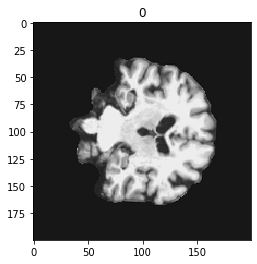

[0,   100] loss: 0.72767
[0,   200] loss: 0.70756
[0,   300] loss: 0.68719
Time elapsed: 0h:0m:27s
train accuracy_score: 55.49 %
val accuracy_score: 60.81 %
Val loss: 0.656350
[1,   100] loss: 0.66180
[1,   200] loss: 0.64898
[1,   300] loss: 0.64307
Time elapsed: 0h:0m:56s
train accuracy_score: 63.08 %
val accuracy_score: 65.54 %
Val loss: 0.642305
[2,   100] loss: 0.60934
[2,   200] loss: 0.64958
[2,   300] loss: 0.63049
Time elapsed: 0h:1m:25s
train accuracy_score: 65.49 %
val accuracy_score: 71.62 %
Val loss: 0.601642
[3,   100] loss: 0.62514
[3,   200] loss: 0.59973
[3,   300] loss: 0.63828
Time elapsed: 0h:1m:53s
train accuracy_score: 65.71 %
val accuracy_score: 69.59 %
Val loss: 0.589621
[4,   100] loss: 0.60899
[4,   200] loss: 0.60528
[4,   300] loss: 0.56456
Time elapsed: 0h:2m:22s
train accuracy_score: 70.38 %
val accuracy_score: 71.62 %
Val loss: 0.601733
[5,   100] loss: 0.55515
[5,   200] loss: 0.55545
[5,   300] loss: 0.55886
Time elapsed: 0h:2m:51s
train accuracy_score:

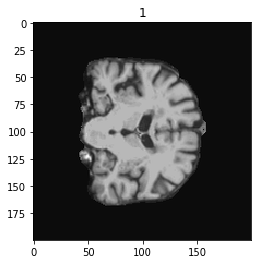

[0,   100] loss: 0.73746
[0,   200] loss: 0.70284
[0,   300] loss: 0.64979
Time elapsed: 0h:0m:27s
train accuracy_score: 56.84 %
val accuracy_score: 68.92 %
Val loss: 0.637709
[1,   100] loss: 0.64319
[1,   200] loss: 0.67113
[1,   300] loss: 0.64056
Time elapsed: 0h:0m:56s
train accuracy_score: 62.78 %
val accuracy_score: 68.92 %
Val loss: 0.615757
[2,   100] loss: 0.57985
[2,   200] loss: 0.59877
[2,   300] loss: 0.64076
Time elapsed: 0h:1m:25s
train accuracy_score: 68.12 %
val accuracy_score: 72.30 %
Val loss: 0.578708
[3,   100] loss: 0.58982
[3,   200] loss: 0.58747
[3,   300] loss: 0.59523
Time elapsed: 0h:1m:53s
train accuracy_score: 68.65 %
val accuracy_score: 70.27 %
Val loss: 0.578470
[4,   100] loss: 0.53755
[4,   200] loss: 0.55097
[4,   300] loss: 0.57741
Time elapsed: 0h:2m:22s
train accuracy_score: 73.31 %
val accuracy_score: 74.32 %
Val loss: 0.568510
[5,   100] loss: 0.55423
[5,   200] loss: 0.52865
[5,   300] loss: 0.52445
Time elapsed: 0h:2m:50s
train accuracy_score:

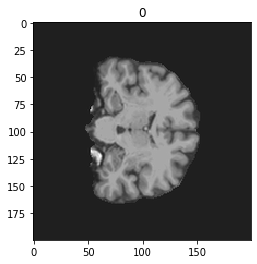

[0,   100] loss: 0.77768
[0,   200] loss: 0.71182
[0,   300] loss: 0.67740
Time elapsed: 0h:0m:46s
train accuracy_score: 55.04 %
val accuracy_score: 59.46 %
Val loss: 0.686897
[1,   100] loss: 0.66861
[1,   200] loss: 0.67060
[1,   300] loss: 0.66262
Time elapsed: 0h:1m:35s
train accuracy_score: 59.47 %
val accuracy_score: 59.46 %
Val loss: 0.659252
[2,   100] loss: 0.63977
[2,   200] loss: 0.62602
[2,   300] loss: 0.58716
Time elapsed: 0h:2m:24s
train accuracy_score: 66.62 %
val accuracy_score: 66.22 %
Val loss: 0.616184
[3,   100] loss: 0.56670
[3,   200] loss: 0.59898
[3,   300] loss: 0.58382
Time elapsed: 0h:3m:13s
train accuracy_score: 69.40 %
val accuracy_score: 73.65 %
Val loss: 0.570563
[4,   100] loss: 0.58883
[4,   200] loss: 0.58450
[4,   300] loss: 0.54946
Time elapsed: 0h:4m:2s
train accuracy_score: 71.35 %
val accuracy_score: 73.65 %
Val loss: 0.553126
[5,   100] loss: 0.55164
[5,   200] loss: 0.51476
[5,   300] loss: 0.53847
Time elapsed: 0h:4m:50s
train accuracy_score: 

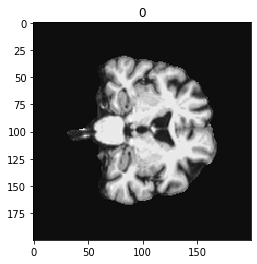

[0,   100] loss: 0.73618
[0,   200] loss: 0.69572
[0,   300] loss: 0.70193
Time elapsed: 0h:0m:29s
train accuracy_score: 56.54 %
val accuracy_score: 59.46 %
Val loss: 0.672008
[1,   100] loss: 0.67603
[1,   200] loss: 0.69225
[1,   300] loss: 0.65516
Time elapsed: 0h:0m:59s
train accuracy_score: 60.15 %
val accuracy_score: 68.24 %
Val loss: 0.645973
[2,   100] loss: 0.67639
[2,   200] loss: 0.64116
[2,   300] loss: 0.62385
Time elapsed: 0h:1m:28s
train accuracy_score: 63.01 %
val accuracy_score: 65.54 %
Val loss: 0.626809
[3,   100] loss: 0.63633
[3,   200] loss: 0.62019
[3,   300] loss: 0.62702
Time elapsed: 0h:1m:59s
train accuracy_score: 65.64 %
val accuracy_score: 66.89 %
Val loss: 0.619796
[4,   100] loss: 0.63274
[4,   200] loss: 0.61758
[4,   300] loss: 0.55067
Time elapsed: 0h:2m:29s
train accuracy_score: 68.87 %
val accuracy_score: 69.59 %
Val loss: 0.580392
[5,   100] loss: 0.58881
[5,   200] loss: 0.60597
[5,   300] loss: 0.53105
Time elapsed: 0h:2m:58s
train accuracy_score:

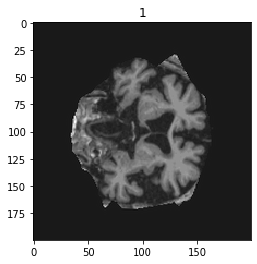

[0,   100] loss: 0.70146
[0,   200] loss: 0.73009
[0,   300] loss: 0.68315
Time elapsed: 0h:0m:28s
train accuracy_score: 56.32 %
val accuracy_score: 62.16 %
Val loss: 0.654678
[1,   100] loss: 0.65400
[1,   200] loss: 0.67057
[1,   300] loss: 0.66319
Time elapsed: 0h:0m:57s
train accuracy_score: 61.50 %
val accuracy_score: 60.81 %
Val loss: 0.650379
[2,   100] loss: 0.66047
[2,   200] loss: 0.66074
[2,   300] loss: 0.65518
Time elapsed: 0h:1m:26s
train accuracy_score: 61.58 %
val accuracy_score: 61.49 %
Val loss: 0.634571
[3,   100] loss: 0.61673
[3,   200] loss: 0.62104
[3,   300] loss: 0.64997
Time elapsed: 0h:1m:59s
train accuracy_score: 64.36 %
val accuracy_score: 56.76 %
Val loss: 0.666169
[4,   100] loss: 0.63298
[4,   200] loss: 0.57826
[4,   300] loss: 0.61692
Time elapsed: 0h:2m:30s
train accuracy_score: 65.19 %
val accuracy_score: 70.27 %
Val loss: 0.596114
[5,   100] loss: 0.60361
[5,   200] loss: 0.56916
[5,   300] loss: 0.58750
Time elapsed: 0h:2m:59s
train accuracy_score:

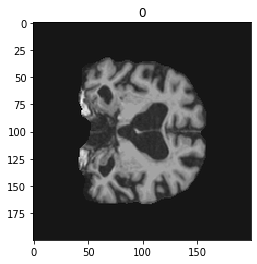

[0,   100] loss: 0.74155
[0,   200] loss: 0.67052
[0,   300] loss: 0.65890
Time elapsed: 0h:0m:27s
train accuracy_score: 56.92 %
val accuracy_score: 47.97 %
Val loss: 0.700437
[1,   100] loss: 0.66735
[1,   200] loss: 0.67396
[1,   300] loss: 0.66017
Time elapsed: 0h:0m:56s
train accuracy_score: 61.05 %
val accuracy_score: 64.19 %
Val loss: 0.625358
[2,   100] loss: 0.63086
[2,   200] loss: 0.62416
[2,   300] loss: 0.61079
Time elapsed: 0h:1m:26s
train accuracy_score: 64.44 %
val accuracy_score: 69.59 %
Val loss: 0.587938
[3,   100] loss: 0.60532
[3,   200] loss: 0.58287
[3,   300] loss: 0.60900
Time elapsed: 0h:1m:55s
train accuracy_score: 69.70 %
val accuracy_score: 72.30 %
Val loss: 0.568442
[4,   100] loss: 0.58490
[4,   200] loss: 0.53441
[4,   300] loss: 0.59400
Time elapsed: 0h:2m:24s
train accuracy_score: 71.28 %
val accuracy_score: 74.32 %
Val loss: 0.541840
[5,   100] loss: 0.57766
[5,   200] loss: 0.54426
[5,   300] loss: 0.53472
Time elapsed: 0h:2m:53s
train accuracy_score:

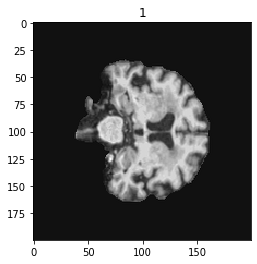

[0,   100] loss: 0.72065
[0,   200] loss: 0.70259
[0,   300] loss: 0.68963
Time elapsed: 0h:0m:27s
train accuracy_score: 57.07 %
val accuracy_score: 59.46 %
Val loss: 0.666896
[1,   100] loss: 0.65664
[1,   200] loss: 0.67129
[1,   300] loss: 0.66726
Time elapsed: 0h:0m:56s
train accuracy_score: 61.13 %
val accuracy_score: 64.86 %
Val loss: 0.632263
[2,   100] loss: 0.60251
[2,   200] loss: 0.62201
[2,   300] loss: 0.64548
Time elapsed: 0h:1m:25s
train accuracy_score: 66.84 %
val accuracy_score: 71.62 %
Val loss: 0.608754
[3,   100] loss: 0.60249
[3,   200] loss: 0.55406
[3,   300] loss: 0.59809
Time elapsed: 0h:1m:54s
train accuracy_score: 69.10 %
val accuracy_score: 66.22 %
Val loss: 0.632153
[4,   100] loss: 0.56659
[4,   200] loss: 0.55701
[4,   300] loss: 0.57933
Time elapsed: 0h:2m:23s
train accuracy_score: 71.05 %
val accuracy_score: 68.24 %
Val loss: 0.582056
[5,   100] loss: 0.55126
[5,   200] loss: 0.56577
[5,   300] loss: 0.56514
Time elapsed: 0h:2m:52s
train accuracy_score:

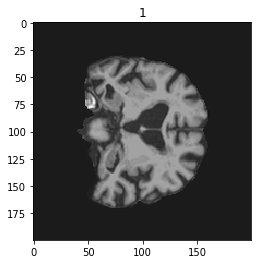

[0,   100] loss: 0.70826
[0,   200] loss: 0.70049
[0,   300] loss: 0.68769
Time elapsed: 0h:0m:28s
train accuracy_score: 56.77 %
val accuracy_score: 61.49 %
Val loss: 0.657743
[1,   100] loss: 0.66292
[1,   200] loss: 0.65866
[1,   300] loss: 0.62697
Time elapsed: 0h:0m:57s
train accuracy_score: 63.61 %
val accuracy_score: 66.22 %
Val loss: 0.627971
[2,   100] loss: 0.64834
[2,   200] loss: 0.64547
[2,   300] loss: 0.60203
Time elapsed: 0h:1m:26s
train accuracy_score: 64.14 %
val accuracy_score: 67.57 %
Val loss: 0.603600
[3,   100] loss: 0.62577
[3,   200] loss: 0.58274
[3,   300] loss: 0.60951
Time elapsed: 0h:1m:55s
train accuracy_score: 67.89 %
val accuracy_score: 70.27 %
Val loss: 0.581485
[4,   100] loss: 0.57860
[4,   200] loss: 0.58512
[4,   300] loss: 0.57834
Time elapsed: 0h:2m:24s
train accuracy_score: 69.17 %
val accuracy_score: 67.57 %
Val loss: 0.577012
[5,   100] loss: 0.58038
[5,   200] loss: 0.54465
[5,   300] loss: 0.55741
Time elapsed: 0h:2m:53s
train accuracy_score:

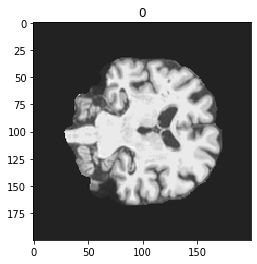

[0,   100] loss: 0.75864
[0,   200] loss: 0.71784
[0,   300] loss: 0.68707
Time elapsed: 0h:0m:27s
train accuracy_score: 55.41 %
val accuracy_score: 58.78 %
Val loss: 0.670289
[1,   100] loss: 0.63323
[1,   200] loss: 0.69047
[1,   300] loss: 0.65988
Time elapsed: 0h:0m:56s
train accuracy_score: 61.95 %
val accuracy_score: 64.19 %
Val loss: 0.644389
[2,   100] loss: 0.64961
[2,   200] loss: 0.65363
[2,   300] loss: 0.59384
Time elapsed: 0h:1m:25s
train accuracy_score: 65.49 %
val accuracy_score: 72.30 %
Val loss: 0.614065
[3,   100] loss: 0.59333
[3,   200] loss: 0.55637
[3,   300] loss: 0.58061
Time elapsed: 0h:1m:55s
train accuracy_score: 69.40 %
val accuracy_score: 68.24 %
Val loss: 0.606901
[4,   100] loss: 0.58903
[4,   200] loss: 0.55265
[4,   300] loss: 0.59286
Time elapsed: 0h:2m:24s
train accuracy_score: 70.38 %
val accuracy_score: 72.97 %
Val loss: 0.582440
[5,   100] loss: 0.52456
[5,   200] loss: 0.58234
[5,   300] loss: 0.56084
Time elapsed: 0h:2m:53s
train accuracy_score:

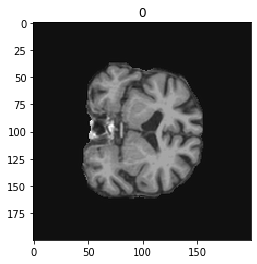

[0,   100] loss: 0.71025
[0,   200] loss: 0.68854
[0,   300] loss: 0.69288
Time elapsed: 0h:0m:27s
train accuracy_score: 55.94 %
val accuracy_score: 57.43 %
Val loss: 0.678219
[1,   100] loss: 0.67448
[1,   200] loss: 0.66255
[1,   300] loss: 0.66008
Time elapsed: 0h:0m:57s
train accuracy_score: 59.47 %
val accuracy_score: 62.84 %
Val loss: 0.649447
[2,   100] loss: 0.66063
[2,   200] loss: 0.66128
[2,   300] loss: 0.65757
Time elapsed: 0h:1m:26s
train accuracy_score: 62.78 %
val accuracy_score: 64.19 %
Val loss: 0.636108
[3,   100] loss: 0.62288
[3,   200] loss: 0.64757
[3,   300] loss: 0.64877
Time elapsed: 0h:1m:55s
train accuracy_score: 65.19 %
val accuracy_score: 63.51 %
Val loss: 0.631574
[4,   100] loss: 0.62934
[4,   200] loss: 0.62730
[4,   300] loss: 0.61191
Time elapsed: 0h:2m:25s
train accuracy_score: 66.02 %
val accuracy_score: 68.24 %
Val loss: 0.591273
[5,   100] loss: 0.59344
[5,   200] loss: 0.56057
[5,   300] loss: 0.58246
Time elapsed: 0h:2m:54s
train accuracy_score:

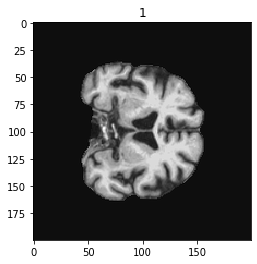

[0,   100] loss: 0.72161
[0,   200] loss: 0.69257
[0,   300] loss: 0.69147
Time elapsed: 0h:0m:28s
train accuracy_score: 56.54 %
val accuracy_score: 65.54 %
Val loss: 0.646805
[1,   100] loss: 0.66832
[1,   200] loss: 0.61710
[1,   300] loss: 0.68153
Time elapsed: 0h:0m:58s
train accuracy_score: 60.30 %
val accuracy_score: 70.27 %
Val loss: 0.629298
[2,   100] loss: 0.64485
[2,   200] loss: 0.65405
[2,   300] loss: 0.63600
Time elapsed: 0h:1m:27s
train accuracy_score: 63.98 %
val accuracy_score: 70.95 %
Val loss: 0.614839
[3,   100] loss: 0.61936
[3,   200] loss: 0.62451
[3,   300] loss: 0.64589
Time elapsed: 0h:1m:56s
train accuracy_score: 66.17 %
val accuracy_score: 71.62 %
Val loss: 0.604999
[4,   100] loss: 0.60206
[4,   200] loss: 0.60250
[4,   300] loss: 0.59747
Time elapsed: 0h:2m:25s
train accuracy_score: 67.74 %
val accuracy_score: 69.59 %
Val loss: 0.594043
[5,   100] loss: 0.60317
[5,   200] loss: 0.58435
[5,   300] loss: 0.59300
Time elapsed: 0h:2m:54s
train accuracy_score:

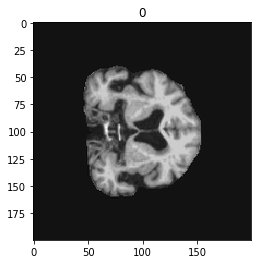

[0,   100] loss: 0.71286
[0,   200] loss: 0.68184
[0,   300] loss: 0.70177
Time elapsed: 0h:0m:28s
train accuracy_score: 56.62 %
val accuracy_score: 68.92 %
Val loss: 0.654537
[1,   100] loss: 0.66952
[1,   200] loss: 0.66997
[1,   300] loss: 0.63576
Time elapsed: 0h:0m:57s
train accuracy_score: 59.55 %
val accuracy_score: 66.22 %
Val loss: 0.639431
[2,   100] loss: 0.66102
[2,   200] loss: 0.65714
[2,   300] loss: 0.64129
Time elapsed: 0h:1m:27s
train accuracy_score: 62.41 %
val accuracy_score: 53.38 %
Val loss: 0.661658
[3,   100] loss: 0.63074
[3,   200] loss: 0.62128
[3,   300] loss: 0.58079
Time elapsed: 0h:1m:56s
train accuracy_score: 68.12 %
val accuracy_score: 72.30 %
Val loss: 0.589980
[4,   100] loss: 0.61437
[4,   200] loss: 0.61310
[4,   300] loss: 0.58489
Time elapsed: 0h:2m:26s
train accuracy_score: 68.80 %
val accuracy_score: 72.97 %
Val loss: 0.564883
[5,   100] loss: 0.56704
[5,   200] loss: 0.61026
[5,   300] loss: 0.57301
Time elapsed: 0h:2m:55s
train accuracy_score:

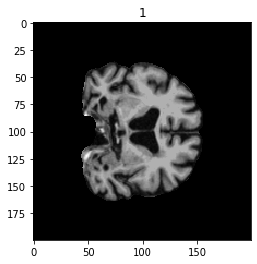

[0,   100] loss: 0.73326
[0,   200] loss: 0.70222
[0,   300] loss: 0.68245
Time elapsed: 0h:0m:28s
train accuracy_score: 56.84 %
val accuracy_score: 59.46 %
Val loss: 0.679132
[1,   100] loss: 0.68481
[1,   200] loss: 0.65960
[1,   300] loss: 0.67858
Time elapsed: 0h:0m:57s
train accuracy_score: 59.10 %
val accuracy_score: 59.46 %
Val loss: 0.661299
[2,   100] loss: 0.64755
[2,   200] loss: 0.62803
[2,   300] loss: 0.65484
Time elapsed: 0h:1m:27s
train accuracy_score: 63.61 %
val accuracy_score: 72.30 %
Val loss: 0.617016
[3,   100] loss: 0.67084
[3,   200] loss: 0.64506
[3,   300] loss: 0.60963
Time elapsed: 0h:1m:56s
train accuracy_score: 64.29 %
val accuracy_score: 74.32 %
Val loss: 0.604900
[4,   100] loss: 0.63498
[4,   200] loss: 0.60571
[4,   300] loss: 0.59337
Time elapsed: 0h:2m:26s
train accuracy_score: 66.77 %
val accuracy_score: 69.59 %
Val loss: 0.594794
[5,   100] loss: 0.59287
[5,   200] loss: 0.59517
[5,   300] loss: 0.53356
Time elapsed: 0h:2m:55s
train accuracy_score:

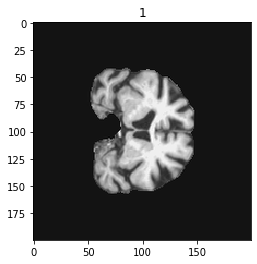

[0,   100] loss: 0.72037
[0,   200] loss: 0.68826
[0,   300] loss: 0.68405
Time elapsed: 0h:0m:28s
train accuracy_score: 59.10 %
val accuracy_score: 58.11 %
Val loss: 0.677975
[1,   100] loss: 0.69321
[1,   200] loss: 0.65855
[1,   300] loss: 0.65886
Time elapsed: 0h:0m:57s
train accuracy_score: 60.53 %
val accuracy_score: 60.81 %
Val loss: 0.649507
[2,   100] loss: 0.66339
[2,   200] loss: 0.63391
[2,   300] loss: 0.63154
Time elapsed: 0h:1m:26s
train accuracy_score: 63.23 %
val accuracy_score: 69.59 %
Val loss: 0.628095
[3,   100] loss: 0.63228
[3,   200] loss: 0.66303
[3,   300] loss: 0.63424
Time elapsed: 0h:1m:56s
train accuracy_score: 62.93 %
val accuracy_score: 63.51 %
Val loss: 0.635935
[4,   100] loss: 0.62865
[4,   200] loss: 0.59082
[4,   300] loss: 0.61634
Time elapsed: 0h:2m:25s
train accuracy_score: 67.14 %
val accuracy_score: 68.92 %
Val loss: 0.596640
[5,   100] loss: 0.58028
[5,   200] loss: 0.59128
[5,   300] loss: 0.57012
Time elapsed: 0h:2m:54s
train accuracy_score:

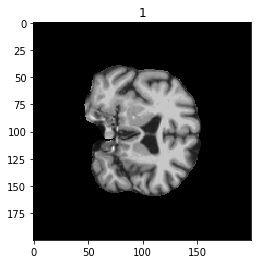

[0,   100] loss: 0.71428
[0,   200] loss: 0.72554
[0,   300] loss: 0.70013
Time elapsed: 0h:0m:28s
train accuracy_score: 56.32 %
val accuracy_score: 60.14 %
Val loss: 0.655750
[1,   100] loss: 0.68257
[1,   200] loss: 0.68259
[1,   300] loss: 0.67152
Time elapsed: 0h:0m:57s
train accuracy_score: 59.10 %
val accuracy_score: 62.16 %
Val loss: 0.644267
[2,   100] loss: 0.66981
[2,   200] loss: 0.64810
[2,   300] loss: 0.64099
Time elapsed: 0h:1m:26s
train accuracy_score: 60.83 %
val accuracy_score: 64.86 %
Val loss: 0.630727
[3,   100] loss: 0.63989
[3,   200] loss: 0.65757
[3,   300] loss: 0.62286
Time elapsed: 0h:1m:54s
train accuracy_score: 65.34 %
val accuracy_score: 70.27 %
Val loss: 0.618977
[4,   100] loss: 0.63666
[4,   200] loss: 0.62468
[4,   300] loss: 0.64275
Time elapsed: 0h:2m:23s
train accuracy_score: 65.11 %
val accuracy_score: 58.78 %
Val loss: 0.642319
[5,   100] loss: 0.63385
[5,   200] loss: 0.61571
[5,   300] loss: 0.58489
Time elapsed: 0h:2m:52s
train accuracy_score:

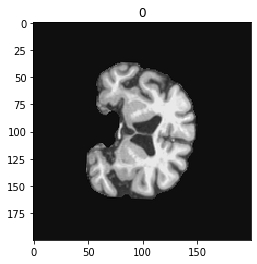

[0,   100] loss: 0.72367
[0,   200] loss: 0.70753
[0,   300] loss: 0.71513
Time elapsed: 0h:0m:27s
train accuracy_score: 56.39 %
val accuracy_score: 59.46 %
Val loss: 0.668858
[1,   100] loss: 0.65664
[1,   200] loss: 0.70638
[1,   300] loss: 0.65332
Time elapsed: 0h:0m:56s
train accuracy_score: 58.95 %
val accuracy_score: 62.16 %
Val loss: 0.662652
[2,   100] loss: 0.67322
[2,   200] loss: 0.66743
[2,   300] loss: 0.65351
Time elapsed: 0h:1m:26s
train accuracy_score: 59.40 %
val accuracy_score: 68.92 %
Val loss: 0.624225
[3,   100] loss: 0.63753
[3,   200] loss: 0.67377
[3,   300] loss: 0.62600
Time elapsed: 0h:1m:55s
train accuracy_score: 63.01 %
val accuracy_score: 62.84 %
Val loss: 0.646657
[4,   100] loss: 0.63723
[4,   200] loss: 0.64415
[4,   300] loss: 0.59847
Time elapsed: 0h:2m:25s
train accuracy_score: 65.71 %
val accuracy_score: 68.92 %
Val loss: 0.613597
[5,   100] loss: 0.62685
[5,   200] loss: 0.54401
[5,   300] loss: 0.61124
Time elapsed: 0h:2m:54s
train accuracy_score:

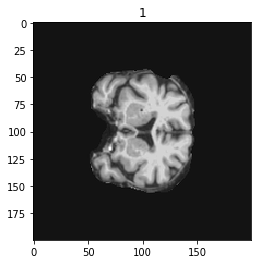

[0,   100] loss: 0.73176
[0,   200] loss: 0.69843
[0,   300] loss: 0.68026
Time elapsed: 0h:0m:28s
train accuracy_score: 56.17 %
val accuracy_score: 61.49 %
Val loss: 0.657909
[1,   100] loss: 0.65603
[1,   200] loss: 0.66626
[1,   300] loss: 0.67352
Time elapsed: 0h:0m:57s
train accuracy_score: 61.13 %
val accuracy_score: 65.54 %
Val loss: 0.642602
[2,   100] loss: 0.64344
[2,   200] loss: 0.64257
[2,   300] loss: 0.64472
Time elapsed: 0h:1m:26s
train accuracy_score: 62.63 %
val accuracy_score: 62.16 %
Val loss: 0.642132
[3,   100] loss: 0.65276
[3,   200] loss: 0.59964
[3,   300] loss: 0.61055
Time elapsed: 0h:1m:55s
train accuracy_score: 65.04 %
val accuracy_score: 66.22 %
Val loss: 0.621878
[4,   100] loss: 0.60250
[4,   200] loss: 0.64042
[4,   300] loss: 0.59462
Time elapsed: 0h:2m:24s
train accuracy_score: 65.34 %
val accuracy_score: 68.92 %
Val loss: 0.606221
[5,   100] loss: 0.61440
[5,   200] loss: 0.60359
[5,   300] loss: 0.53837
Time elapsed: 0h:2m:53s
train accuracy_score:

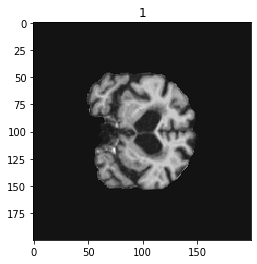

[0,   100] loss: 0.74274
[0,   200] loss: 0.71750
[0,   300] loss: 0.67652
Time elapsed: 0h:0m:29s
train accuracy_score: 57.14 %
val accuracy_score: 57.43 %
Val loss: 0.666721
[1,   100] loss: 0.70089
[1,   200] loss: 0.65390
[1,   300] loss: 0.65724
Time elapsed: 0h:1m:0s
train accuracy_score: 59.40 %
val accuracy_score: 64.86 %
Val loss: 0.633539
[2,   100] loss: 0.64484
[2,   200] loss: 0.65713
[2,   300] loss: 0.64931
Time elapsed: 0h:1m:35s
train accuracy_score: 63.31 %
val accuracy_score: 70.95 %
Val loss: 0.614091
[3,   100] loss: 0.62466
[3,   200] loss: 0.64741
[3,   300] loss: 0.59193
Time elapsed: 0h:2m:9s
train accuracy_score: 66.39 %
val accuracy_score: 69.59 %
Val loss: 0.605386
[4,   100] loss: 0.60508
[4,   200] loss: 0.61768
[4,   300] loss: 0.63845
Time elapsed: 0h:2m:42s
train accuracy_score: 67.07 %
val accuracy_score: 72.97 %
Val loss: 0.591398
[5,   100] loss: 0.58747
[5,   200] loss: 0.60481
[5,   300] loss: 0.54678
Time elapsed: 0h:3m:14s
train accuracy_score: 6

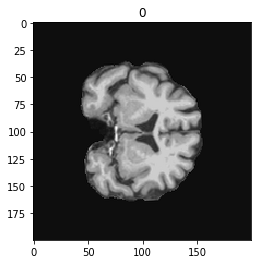

[0,   100] loss: 0.73535
[0,   200] loss: 0.70494
[0,   300] loss: 0.68712
Time elapsed: 0h:0m:30s
train accuracy_score: 54.89 %
val accuracy_score: 66.22 %
Val loss: 0.658214
[1,   100] loss: 0.69039
[1,   200] loss: 0.67408
[1,   300] loss: 0.66157
Time elapsed: 0h:1m:2s
train accuracy_score: 58.20 %
val accuracy_score: 59.46 %
Val loss: 0.680369
[2,   100] loss: 0.66250
[2,   200] loss: 0.67568
[2,   300] loss: 0.65426
Time elapsed: 0h:1m:36s
train accuracy_score: 58.57 %
val accuracy_score: 61.49 %
Val loss: 0.658277
[3,   100] loss: 0.63011
[3,   200] loss: 0.63303
[3,   300] loss: 0.63035
Time elapsed: 0h:2m:6s
train accuracy_score: 63.68 %
val accuracy_score: 54.05 %
Val loss: 0.664877
[4,   100] loss: 0.61078
[4,   200] loss: 0.60248
[4,   300] loss: 0.62989
Time elapsed: 0h:2m:38s
train accuracy_score: 65.71 %
val accuracy_score: 56.76 %
Val loss: 0.645502
[5,   100] loss: 0.61019
[5,   200] loss: 0.61423
[5,   300] loss: 0.62077
Time elapsed: 0h:3m:7s
train accuracy_score: 67

In [15]:
for z_slice in range(0, 10):
    print('Starting slice {}'.format(z_slice))
    
    x_train_z = crop(x_train, z_slice=z_slice, dims=(200, 200))
    x_train_z = min_max(x_train_z)
    x_val_z = crop(x_val, z_slice=z_slice, dims=(200, 200))
    x_val_z = min_max(x_val_z)
    
    print(x_train_z.shape)
    print(x_val_z.shape)
    #print(y_train.shape)
    #print(y_val.shape)
    #print(sum(y_train))
    #print(sum(y_val))

    # https://github.com/moboehle/Pytorch-LRP/blob/master/ADNI%20Training.ipynb
    class ADNIDataset(Dataset):
        def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=torch.float32, num_classes=2):
            self.X = np.copy(X)
            self.y = np.copy(y)
            self.X = X
            self.y = y
            self.transform = transform
            self.target_transform = target_transform
            self.mask = mask
            self.z_factor = z_factor
            self.dtype = dtype
            self.num_classes = num_classes

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            image = self.X[idx]
            label_tensor = np.zeros(shape=(self.num_classes,))
            label = self.y[idx] >= 0.5
            label = torch.LongTensor([label])

            if self.transform:
                image = self.transform(image)

            sample = {"image" : image,
                     "label" : label}
            return sample
    
    augmentations = [nitransform.SagittalRotate()]
    adni_data_train = ADNIDataset(x_train_z[:,0,:,:], y_train, transform = transforms.Compose(augmentations + [nitransform.ToTensor()]), 
                                  dtype=torch.float32)
    adni_data_val = ADNIDataset(x_val_z, y_val)
    # https://github.com/moboehle/Pytorch-LRP/blob/master/ADNI%20Training.ipynb for reference
    class ClassificationModel2D(nn.Module):

        def __init__(self, dropout=0.4, dropout2=0.4):
            nn.Module.__init__(self)
            self.Conv_1 = nn.Conv2d(1, 8, 3)
            self.Conv_1_bn = nn.BatchNorm2d(8)
            self.Conv_1_mp = nn.MaxPool2d(2)
            self.Conv_2 = nn.Conv2d(8, 16, 3)
            self.Conv_2_bn = nn.BatchNorm2d(16)
            self.Conv_2_mp = nn.MaxPool2d(3)
            self.Conv_3 = nn.Conv2d(16, 32, 3)
            self.Conv_3_bn = nn.BatchNorm2d(32)
            self.Conv_3_mp = nn.MaxPool2d(2)
            self.Conv_4 = nn.Conv2d(32, 64, 3)
            self.Conv_4_bn = nn.BatchNorm2d(64)
            self.Conv_4_mp = nn.MaxPool2d(3)
            self.dense_1 = nn.Linear(1024, 128)
            self.dense_2 = nn.Linear(128, 2)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(dropout)
            self.dropout2 = nn.Dropout(dropout2)

        def forward(self, x):
            x = x.float()
            x = self.relu(self.Conv_1_bn(self.Conv_1(x)))
            x = self.Conv_1_mp(x)
            x = self.relu(self.Conv_2_bn(self.Conv_2(x)))
            x = self.Conv_2_mp(x)
            x = self.relu(self.Conv_3_bn(self.Conv_3(x)))
            x = self.Conv_3_mp(x)
            x = self.relu(self.Conv_4_bn(self.Conv_4(x)))
            x = self.Conv_4_mp(x)
            x = x.view(x.size(0), -1)
            x = self.dropout(x)
            x = self.relu(self.dense_1(x))
            x = self.dropout2(x)
            x = self.dense_2(x)
            return x

    net = ClassificationModel2D().float()

    # https://github.com/moboehle/Pytorch-LRP/blob/master/ADNI%20Training.ipynb
    def run(
        net,
        data,
        shape,
        callbacks=[],
        augmentations=[],
        masked=False,
        metrics=[],
        k_folds=None,
        b=4,
        num_epochs=40,
        retain_metric=None):      

        fold_metric = []
        models = []
        fold = 0
        initial_prepend = None
        
        # set number of cross-validation folds
        for trial in range(5):
            print("Starting trial {}".format(trial))

            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
            fold += 1

            # restart model
            del net
            net = ClassificationModel2D().float()

            # reset hyperparameters
            lr = 1e-4
            wd = 1e-4
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

            train_loader = DataLoader(adni_data_train, batch_size=b, num_workers=0, shuffle=True)
            val_loader = DataLoader(adni_data_val, batch_size=1, num_workers=0, shuffle=True)

            # plot slice (optional)
            sample = next(iter(train_loader))
            img = sample["image"][0]
            lbl = sample["label"][0]
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(lbl.item())
            plt.show()
            model_trainer = trainer.Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=None,
                device=torch.device("cpu"),
                prediction_type="classification")

            # train model and store results
            net, report = model_trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=100,
                show_validation_epochs=1)
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                fold_metric.append(report["val_metrics"][retain_metric][-1])
            else:
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

            models.append(net)
            print("Finished fold.")

            # visualize result (optional)
            #model_trainer.visualize_training(report, metrics)
            #model_trainer.evaluate_model(val_loader)

        print("################################")
        print("################################")
        print("All accuracies: {}".format(fold_metric))
        return fold_metric, models

    net = ClassificationModel2D().float()
    num_epochs = 40
    min_iters = 3
    ignore_epochs = 15
    normalize = False
    retain_metric = accuracy_score
    metrics = [accuracy_score]
    model_path = './trained_cn_ad_mri'
    r = 0

    check = ModelCheckpoint(path=model_path,
                            prepend="repeat_{}".format(r),
                            store_best=True,
                            ignore_before=ignore_epochs,
                            retain_metric=retain_metric)
    callbacks = [check, EarlyStopping(patience=10, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]

    fold_metric, models = run(net=net, data=adni_data_train,
                      k_folds=-1,
                      callbacks=None,
                      shape=-1,
                      masked=False,
                      metrics=metrics,
                      num_epochs=num_epochs,
                      retain_metric=retain_metric,
                      b=4,
                     )

    print(np.mean(fold_metric))
    print(np.std(fold_metric))
    best = np.array(fold_metric).argmax()
    torch.save(models[best].state_dict(), model_path + '/' + '2D_Slice_' + str(z_slice))

# Classify the holdout set
## Start here if models are already trained

In [25]:
# locate the holdout images
dir = ('./MRI_Data/MRI_holdout/') # change this to directory with MRI images     
files = os.listdir(dir)

# load conversion dataframe
df_holdout = pd.read_csv('../processed_data/holdout.csv')

# make sure there are no subjects in both training and holdout groups
for i in df['Subject']:
    if any(df_holdout['PTID'] == i):
        print('Failed')
        break

holdout = df_holdout[df_holdout['Modality'] == 'MRI']

# load in holdout images and create labels
group = []
for i in range(len(files)):
    idx = files[i][5:15]
    group.append(holdout.loc[holdout.PTID==idx,'AD_conv'].values[0]) 

group = np.array(group)
ims = np.array([nib.load(dir + file).get_fdata()[:,72:152:8,:,:] for file in files])
print(ims.shape)
print(group.shape)
print(sum(group))

(176, 256, 10, 256, 1)
(176,)
42


In [191]:
y_hat = []
accuracies = []
with torch.no_grad():
    for z_slice in range(10):
        x_test_z = crop(ims, z_slice=z_slice, dims=(200, 200))
        x_test = min_max(x_test_z)
        test_loader = DataLoader(ADNIDataset(x_test, group), batch_size=1, num_workers=0, shuffle=False)
        all_preds = []
        all_labels = []
        model = ClassificationModel2D()
        model.load_state_dict(torch.load(model_path + '/' + os.listdir(model_path)[z_slice]))
        model.eval()
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device('cpu'))
            output = model.forward(img)
            #pred = torch.argmax(F.softmax(output, dim=1)[0][1]) #uncomment and remove below if 50% threshold desired
            pred = F.softmax(output, dim=1)[0][1]
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
        #print(all_preds)
        #print(all_labels)
        #print(classification_report(all_labels, all_preds)) #only uncomment if pred values are binary
        y_hat.append(all_preds)
        #accuracies.append(classification_report(all_labels, all_preds, output_dict = True)['accuracy']) #only uncomment if pred values are binary
        del model
y_test = group.astype(int)
# prediction threshold can be changed
y_hat = ((np.mean(y_hat, axis = 0) >= .4)/1).astype(int)
print(y_test)
print(y_hat)
print(classification_report(y_test, y_hat))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1
 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       134
           1       0.50      0.17      0.25        42

    accuracy                           0.76       176
   macro avg       0.64      0.56      0.55       176
weighted avg

# Visualize the mispredictions

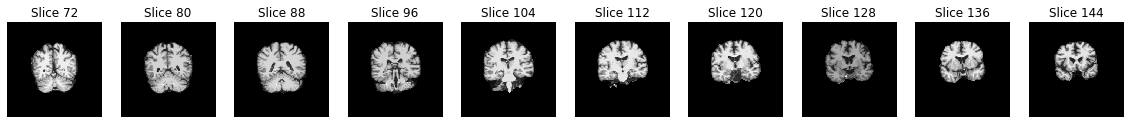

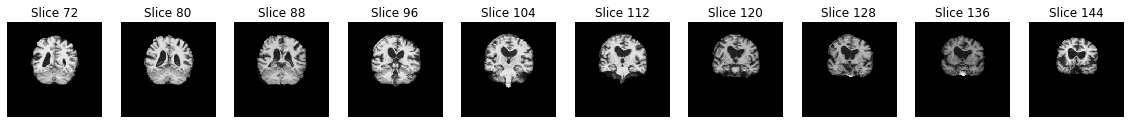

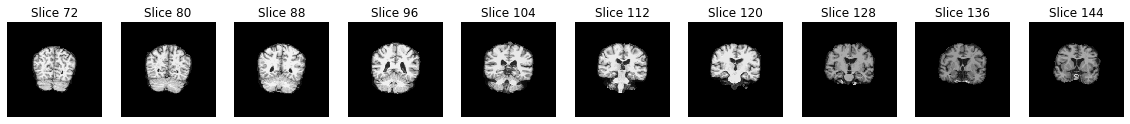

In [201]:
def show_slices(image):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    for i in range(10):
        axes[i].imshow(image[:, i ,:].T, cmap="gray", origin="lower")
        axes[i].axis('off')
        axes[i].set_title('Slice {}'.format(72 + 8 * i))

# false CN
show_slices(ims[-14,:,:,:,0])
# correct AD
show_slices(ims[-19,:,:,:,0])
# correct CN
show_slices(ims[0,:,:,:,0])

# Save results for analysis

In [133]:
ptid = []
for i in range(176):
    ptid.append(files[i][5:15])
    
df = pd.DataFrame(ptid, columns=['Subject'])
df['MRI CNN Prediction'] = y_hat
df
mri_holdout = pd.read_csv('./MRI_Data/MRI_csv/MRI_Holdout_5_04_2021.csv')
mri_holdout['MRI CNN Prediction'] = y_hat
mri_holdout.to_csv('./ADNI/processed_data/holdout_with_MRI_ensemble.csv')